# Physics Informed Neural Networks

PINNs are an emerging 'type' of neural network, that is used mainly to solve physical problems that require computationally intensive solutions for PDEs and ODEs. 

Solving PDEs using Finite Difference Methods and Finite Element Methods means large matrix computations need to be done in order to reach a solution, providing a problem with a polynomial time complexity $O(n^3)$ for each matrix multiplication needed at each time step. This is a computationally intensive problem to solve, as it requires large computational power not available to many people, often needed GPUs to do the efficient computations. For larger systems, or highly non-linear PDEs, solutions computed with GPUs could still be too slow. Another limitation of these methods is that they require meshing, meaning the discretization of the set or region that the solution is found over. This further limits the resulting solution in terms of finenesss and resolution.

In come NNs, serving as universal approximators, with the capability of approximating essentially any function. This property allows for unprecedented flexibility in curve-fitting, with the constraints of specific functional forms a thing of the past. But how does this help solve a differential equation? In an experimental setting, the natural process being described by the PDE/ODE/Otherwise can be measured experimentally and sampled at different points or paths. This data can then be used to train NNs to generalize these results. 

However, only so much data could be produced by these experiments. This causes the training process to be difficult and rife with overfitting. More importantly, the NNs had no 'regard' for physical constraints, the predictions made by NNs were overfit so it did not obey basic conservation laws such as conservation of momentum, mass-energy, flow, etc. 

In a wonderful, in my opinion revolutionary, paper by Maziar Raissi, Paris Perdikaris, and George Em Karniadakis, they introduce the Physics-informed Neural Network. In an implementation that solves the prior problems with a simple technique of regularization based on common PDE constraints such as Dirichlet/VN/Robin Boundary conditions. It also suggests regularization by placing constraints in terms of conservation laws or rather fundamental laws for the system at hand (ex. The square-integrability of the wave function in case of the Schrodinger Wave Equation).

In this example, I'm using a python package called DeepXDE for physics-informed machine learning developed by George Em Karniadakis at Brown University and now maintained by Lu Lu at UPenn and other honorable members of the Lu Lu group. I highly recommend the reader go over their work, it is very interesting and I am for sure a great fan of their work.

In this small project we will focus on solutions for the Fokker-Planck equation in it's 2nd order form.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy 
import seaborn as sns
import scienceplots

plt.style.use(['science'])

First we find the analytical solution, to which we will compare the PINN solution. We start with writing the equation to be solved:

$\frac{\partial{}}{\partial{t}} p(x,t)= -  \frac{\partial{}}{\partial{x}} (D_1(x,t)p(x,t))+  \frac{\partial^2{}}{\partial{x}^2} (D_2(x,t)p(x,t))$

with initial condition:

$p(x,t) = \delta(x)$

and constraint:

$\int_{-\infty}^{\infty} p(x,t) dx = 1$

let's define the following:

$ \mathcal{F}\{ p(x,t) \} = \Pi (k,t)$

where $\mathcal{F}$ is the Fourier transform operator with respect to distance:

$\mathcal{F} \{g(x) \} = \int_{-\infty}^{\infty} g(x) e^{ikx} dx = G(k)$

$\mathcal{F}^{-1} \{G(k) \} = \int_{-\infty}^{\infty} G(k) e^{-ikx} dk = g(x)$

assuming $D_1(x,t), D_2(x,t)$ are slowly varying functions, ie. approximately constant, then we can do:

$\frac{\partial{}}{\partial{t}} \Pi (k,t)= - D_1 i k \Pi (k,t) - D_2 k^2 \Pi (k,t) = - \Pi (k,t) (D_1 i k + D_2 k^2)$

We can then find a partial solution:

$\Pi (k,t) = \Pi (k,0) e ^ {- (D_1 i k + D_2 k^2)t}$

$\Pi (k,0) = \mathcal{F} \{ \delta(x) \} = 1$

$\Pi (k,t) = e ^ {- (D_1 i k + D_2 k^2)t} = e ^ {- i k D_1 t} e ^ {- D_2 k^2 t}$ 

let $ Q(k,t) = e ^ {- D_2 k^2 t} = \mathcal{F} \{ q(x, t) \}$ 

then by:

$ \mathcal{F}^{-1} \{ F(k)e^{-j k x_0} \} = f(x-x_0)$
 
the following is true:

$ \mathcal{F}^{-1} \{\Pi (k,t)\} = \mathcal{F}^{-1} \{Q(k,t) e ^ {- i k D_1 t} \} = q(x-D_1 t, t)$

Recall the identity:

$\mathcal{F} \{ \frac{e^{\frac{-k^2}{4\alpha}}}{(2 \alpha)^{1/2}} \} = e^{-\alpha x^2} $

then it would be useful to express $Q(k,t)$ in an equivalent form:

$Q(k,t) = \frac{1}{A(D_2, t)} A(D_2, t) e ^ {- D_2 k^2 t}$

$ q(x, t) = \frac{1}{A(D_2, t)} \mathcal{F}^{-1} \{ A(D_2, t) e ^ {- D_2 k^2 t} \} $

$  A(D_2, t) e ^ {- D_2 k^2 t} = \frac{e^{\frac{-k^2}{4\alpha}}}{(2 \alpha)^{1/2}}$

$ D_2 t = \frac{1}{4 \alpha} \rightarrow \alpha = \frac{1}{4 D_2 t}$

$ A(D_2, t) = \frac{1}{(2 \alpha)^{1/2}} = \frac{1}{( \frac{1}{2 D_2 t})^{1/2}}= {(2 D_2 t)}^{1/2}$

$\therefore q(x, t) = \frac{1}{{(2 D_2 t)}^{1/2}} e^{-\frac{x^2}{4 D_2 t} }$

Shifting by $D_1 t$, we get:

$p(x, t) = q(x-D_1 t, t) = \frac{1}{{(2 D_2 t)}^{1/2}} e^{-\frac{(x-D_1 t)^2}{4 D_2 t}}$

Letting $D_1 = \mu$ and $D_2 = \sigma^2$:

$p(x, t) = \frac{1}{{(2 \sigma^2 t)}^{1/2}} e^{-\frac{(x-\mu t)^2}{4 \sigma^2 t}}$

Text(0.5, 1.0, 'FP Analytical Solution Contour')

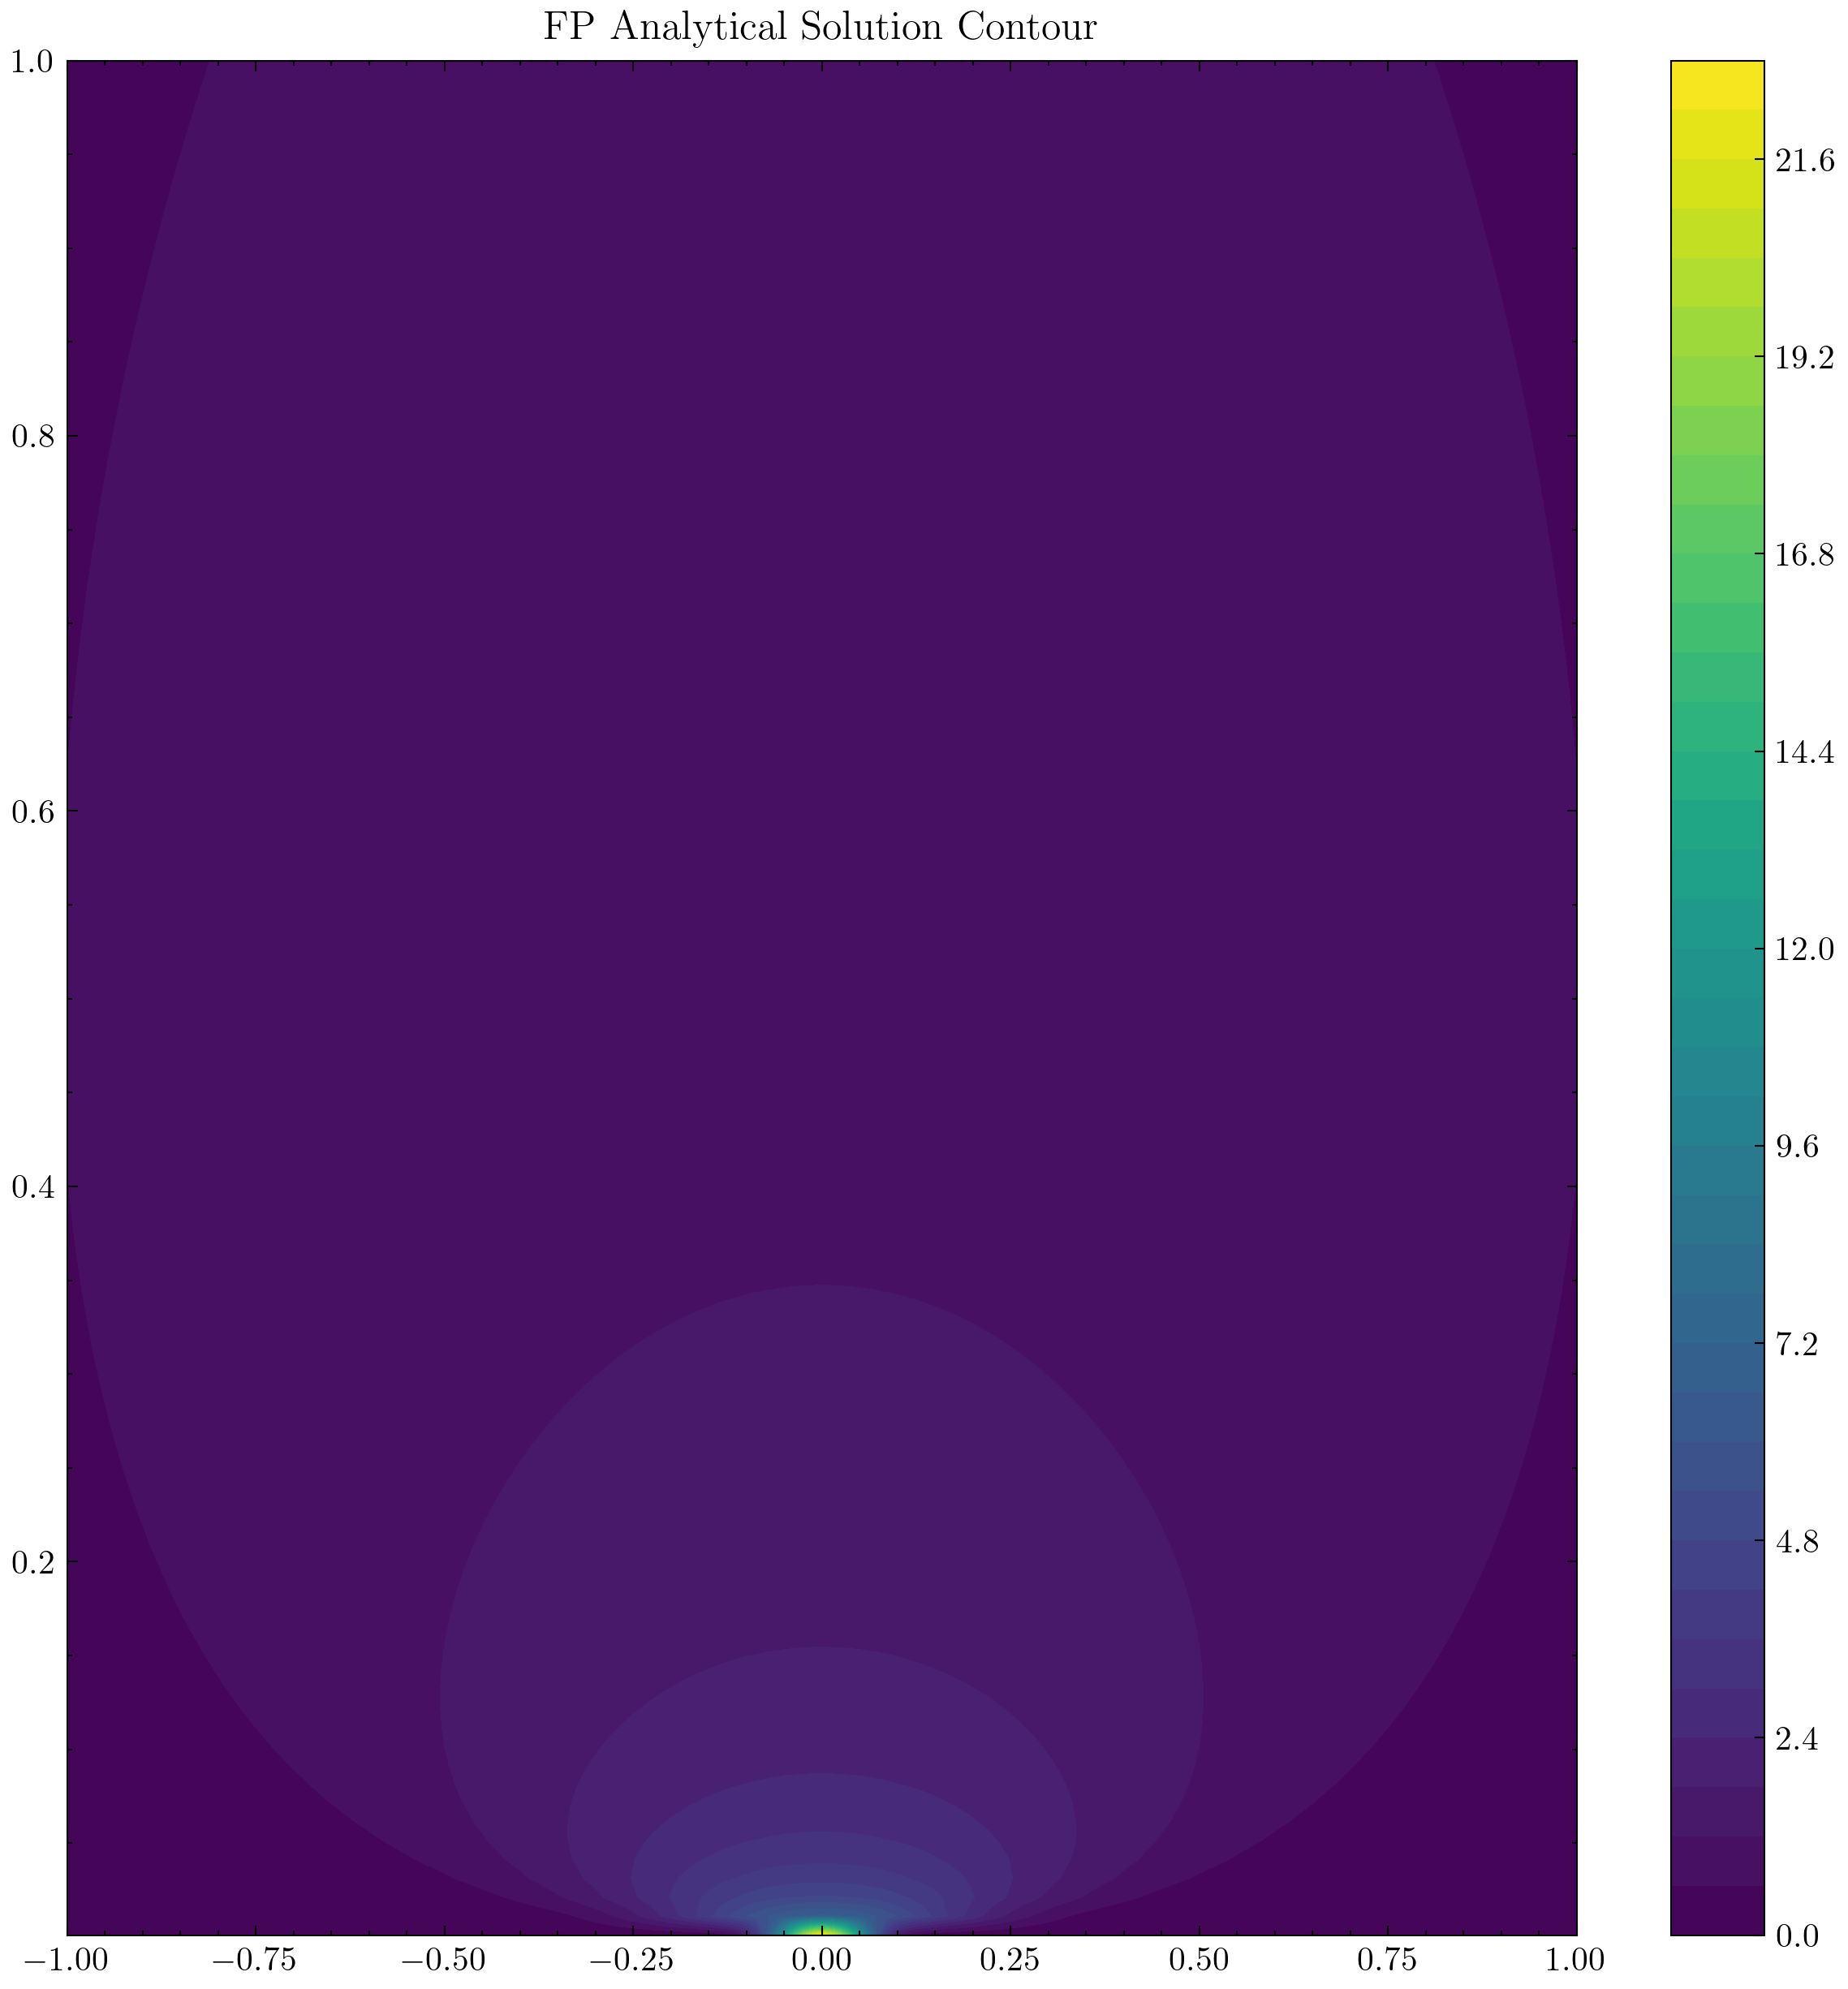

In [15]:
x_lower = -1
x_upper = 1

t_lower = 0
t_upper = 1

space = np.linspace(x_lower,x_upper,200)
time = np.linspace(1e-3,t_upper,100)

mu = -(0)**2/2
sigma = 1

Pxt = lambda x,t : np.exp(-(x - mu*t)**2/(4*sigma**2*t))/(sigma*np.sqrt(2*t))

xx,yy = np.meshgrid(space,time)
fig, ax = plt.subplots(1,1,figsize = (10,10), dpi = 300)

im = ax.contourf(xx,yy,Pxt(xx,yy), levels = 40)

fig.colorbar(im, ax=ax)

ax.set_title('FP Analytical Solution Contour')

In [4]:
import deepxde as dde
from scipy.interpolate import griddata


space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [5]:

# The PDE residual is written in terms of TF grammar
def FP_eqn(x,y):
    y_t = dde.grad.jacobian(y,x, i = 0, j = 1)

    y_x = dde.grad.jacobian(y,x, i = 0, j = 0)
    y_xx = dde.grad.hessian(y,x, i = 0, j = 0)
    y_xxx = dde.grad.jacobian(y_xx,x, i = 0, j = 0)
    y_xxxx = dde.grad.hessian(y_xx,x, i = 0, j = 0)

    resid = y_t + mu*y_x - sigma**2 *y_xx
    return resid

# Initial conditions
from scipy.stats import norm
def initial_cond_prob(x):
    x_0 = x[:,0:1]
    y_0 = norm(0,10**-3).pdf(x_0)
    return y_0
ic = dde.icbc.IC(geomtime, initial_cond_prob, lambda _, on_initial: on_initial)

# boundary conditions
BC_prob = lambda x: np.zeros(len(x))
bc = dde.icbc.boundary_conditions.DirichletBC(geomtime, BC_prob,lambda _, on_boundary: on_boundary)

In [6]:
# create model

data = dde.data.TimePDE(
    geomtime,
    FP_eqn,
    [ic, bc],
    num_domain=10**2,
    num_initial=10**2,
    num_boundary=10**2,
    num_test=10**2,
    train_distribution='uniform'
)

# declare Neural Network and architecture

net = dde.nn.FNN([2] + [100] + [80] + [40] + [1], 'tanh', "Glorot normal")

model = dde.Model(data, net)

dde.callbacks.EarlyStopping(min_delta = 10**-4, patience=500, baseline=10**-9)

In [11]:
model.compile("adam", lr=1e-2, loss="MSE")
model.train(iterations=10000, display_every=1000)

Compiling model...
'compile' took 0.019692 s



Training model...

Step      Train loss                        Test loss                         Test metric
10000     [9.50e-03, 1.34e+02, 1.75e-02]    [8.88e-03, 1.34e+02, 1.75e-02]    []  
10100     [6.60e+01, 1.34e+02, 1.64e-02]    [2.80e+00, 1.34e+02, 1.64e-02]    []  
10200     [2.76e+01, 1.34e+02, 2.67e-02]    [1.82e+00, 1.34e+02, 2.67e-02]    []  
10300     [1.49e+01, 1.34e+02, 5.28e-02]    [1.39e+00, 1.34e+02, 5.28e-02]    []  
10400     [8.68e+00, 1.34e+02, 5.63e-02]    [1.14e+00, 1.34e+02, 5.63e-02]    []  
10500     [5.41e+00, 1.34e+02, 5.64e-02]    [9.79e-01, 1.34e+02, 5.64e-02]    []  
10600     [3.66e+00, 1.34e+02, 5.63e-02]    [8.77e-01, 1.34e+02, 5.63e-02]    []  
10700     [2.65e+00, 1.34e+02, 5.62e-02]    [8.05e-01, 1.34e+02, 5.62e-02]    []  
10800     [2.02e+00, 1.34e+02, 5.62e-02]    [7.49e-01, 1.34e+02, 5.62e-02]    []  
10900     [1.60e+00, 1.34e+02, 5.61e-02]    [7.01e-01, 1.34e+02, 5.61e-02]    []  
11000     [1.32e+00, 1.34e+02, 5.60e-02]    [6.58e-01, 1.34e+

(<deepxde.model.LossHistory at 0x253ac41fc10>,
 <deepxde.model.TrainState at 0x253a2cf8350>)

In [12]:
x = np.linspace(x_lower, x_upper, 200)
t = np.linspace(t_lower, t_upper, 100)
X, T = np.meshgrid(x, t)

# The whole domain flattened
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
prediction = model.predict(X_star, operator=None)

Text(0.5, 1.0, 'FP PINN Numerical Solution Contour')

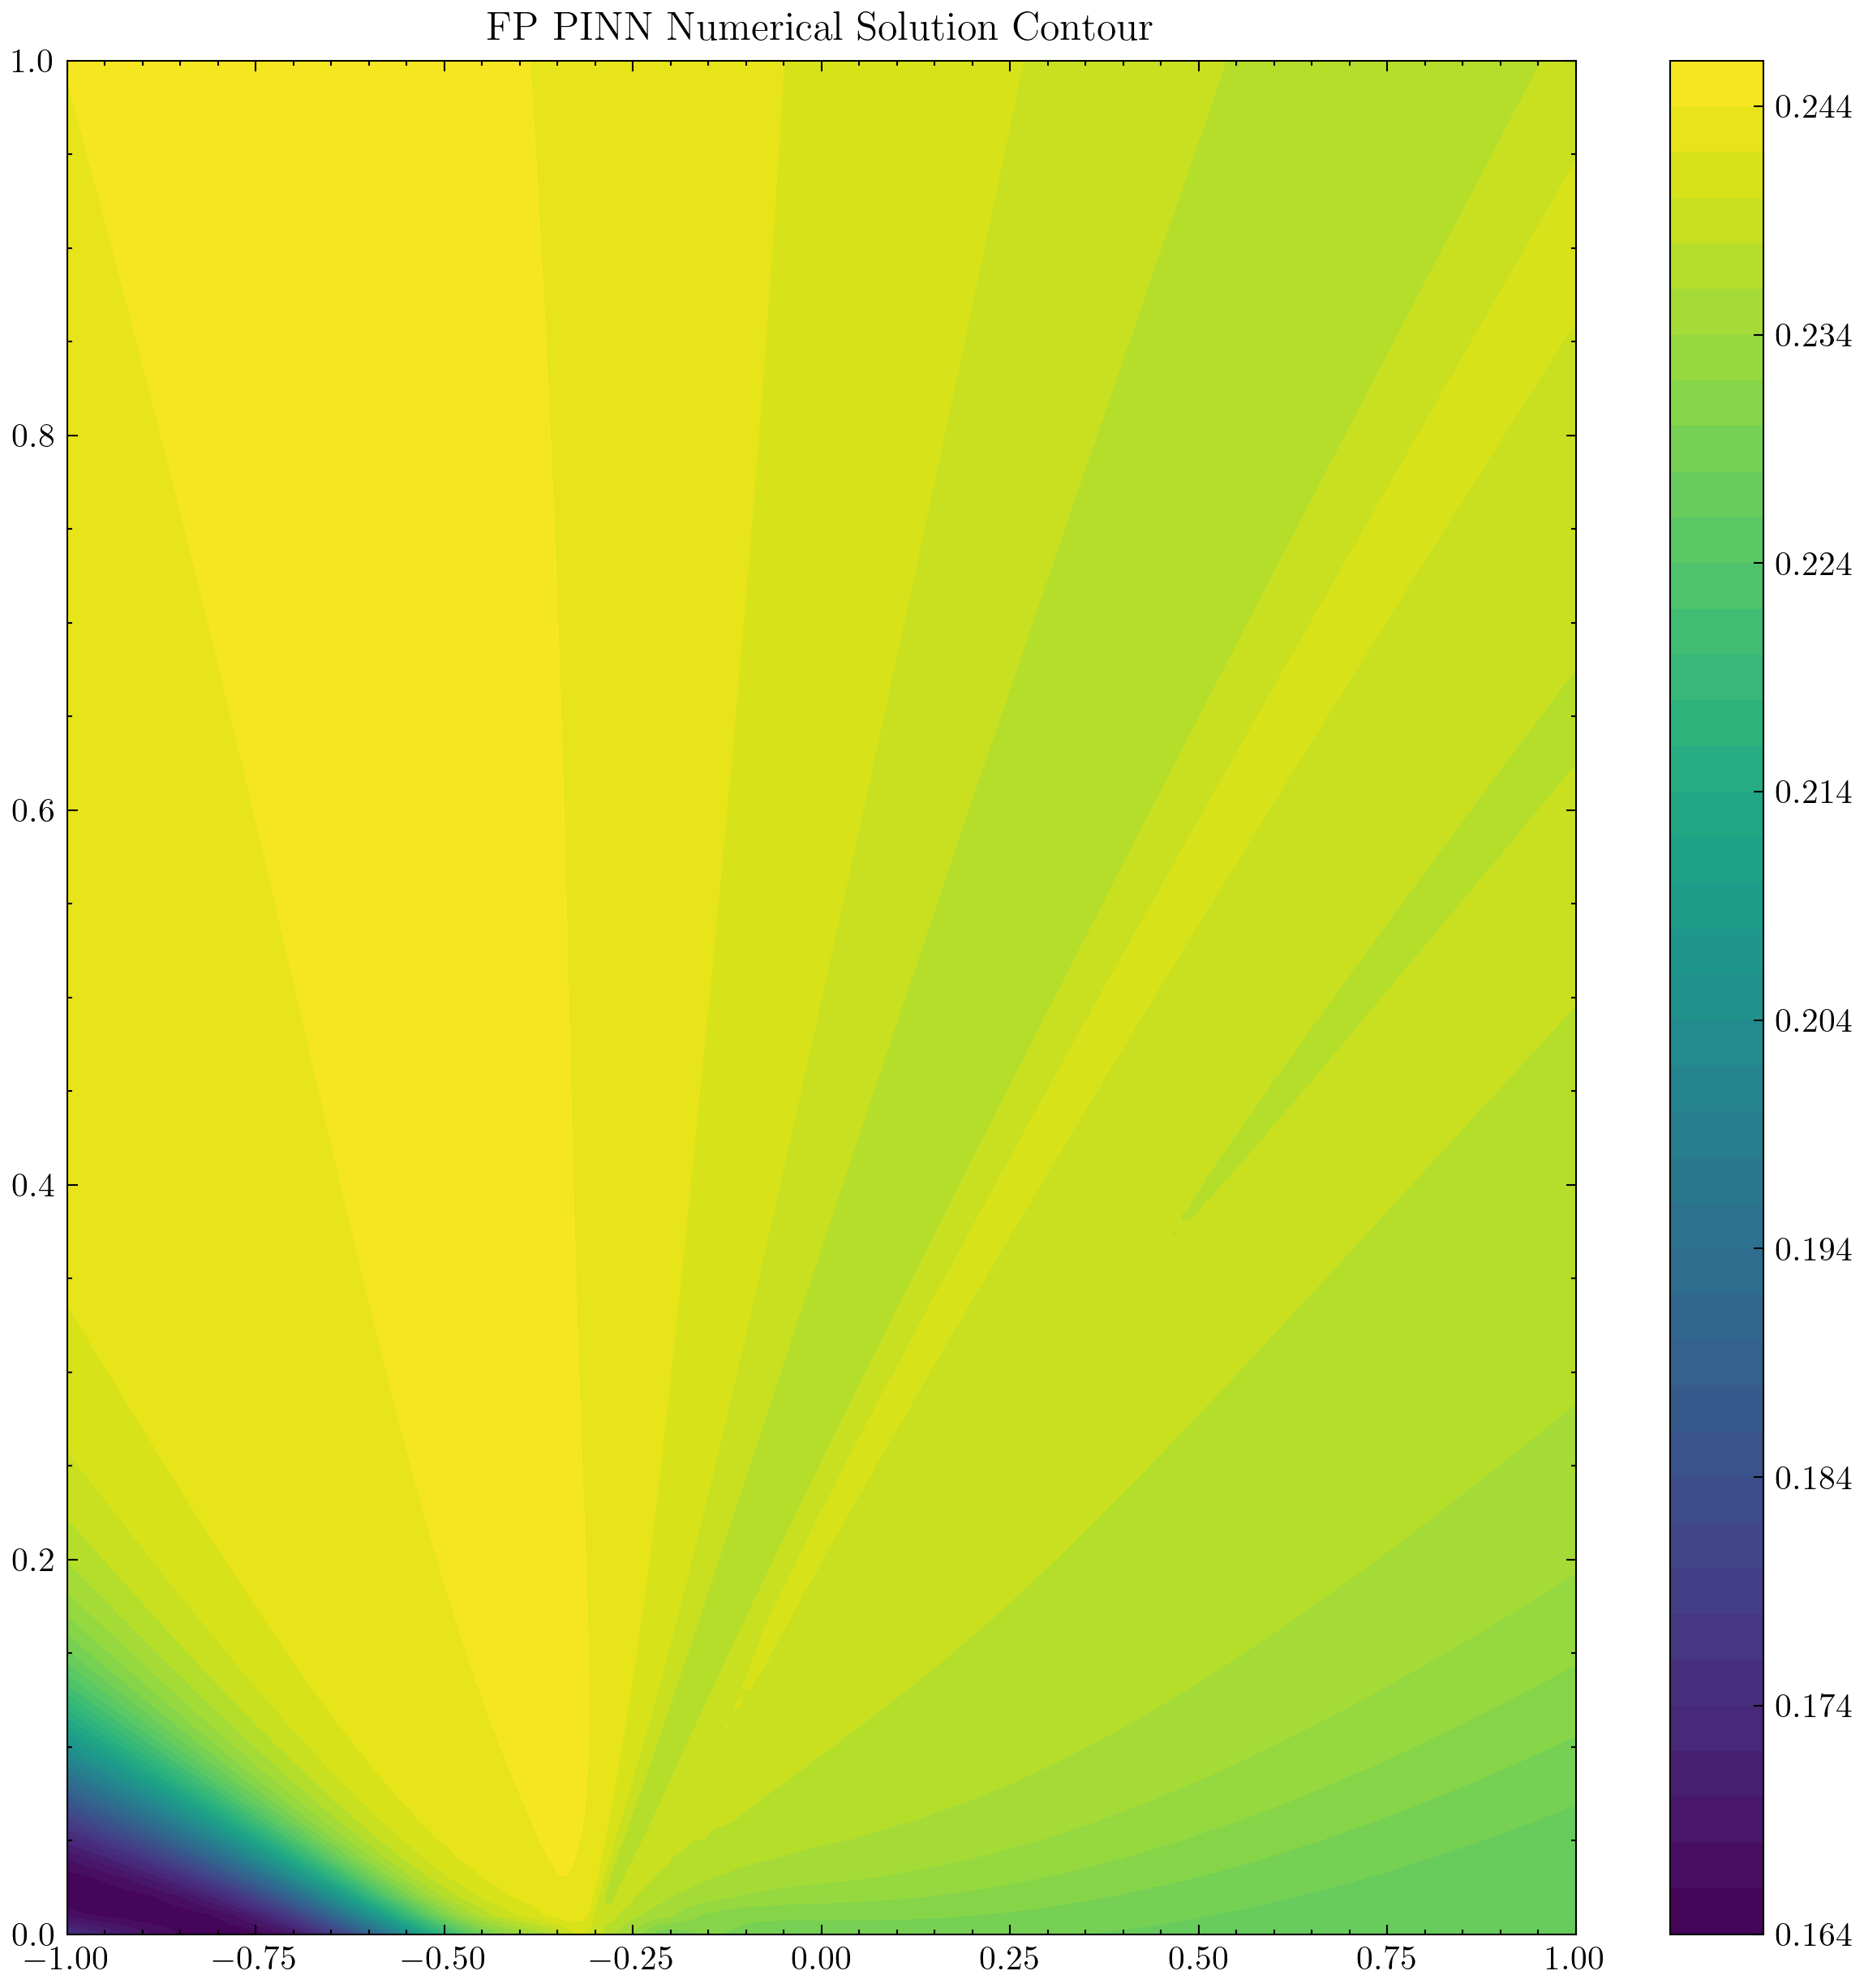

In [16]:
fig, ax = plt.subplots(1,1,figsize =(10,10), dpi = 300)

im = ax.contourf(X,T, prediction.reshape(100,200), levels = 40)

fig.colorbar(im, ax=ax)

ax.set_title('FP PINN Numerical Solution Contour')